<a href="https://colab.research.google.com/github/CarloGiorgio/carlogiorgio/blob/master/Optics/Shape_BPM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Integrazione BPM con Python
## Propagazione attraverso fenditura di diversa forma

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
import time

#metti GPU e funziona!
try:
  import cupy as cp
except ModuleNotFoundError:
  !curl https://colab.chainer.org/install | sh -
  import cupy as cp

fft2,ifft2=cp.fft.fft2,cp.fft.ifft2

In [0]:
from matplotlib import path

#creazione poligono regolare

#array con posizione poligono regolare
def poly(n):
    poli=[]
    for i in range(n+1):
        x=np.cos(2*np.pi/n*i)
        y=np.sin(2*np.pi/n*i)
        poli+=[[x,y]]
    return np.asarray(poli)

#restituisce array booleano che identifica i punti interni
def inpolygon(r, n):
    xq=cp.asnumpy(X.reshape(-1))
    yq=cp.asnumpy(Y.reshape(-1))
    poli=path.Path(poly(n)*r)
    XY=np.asarray([xq,yq]).T.reshape(nx*nx,2)
    return(poli.contains_points(XY).reshape((nx,nx)))

In [0]:
#Intensità sul piano di cintola

def cint(r,gaus=False,n=None,babi=False,w=[0.8e-3,0.8e-3]):

    if gaus:
        w=cp.asarray(w)
        w0x=w[0]
        w0y=w[1]
        I=cp.sqrt(Ip)*cp.exp(-(X/w0x)**2-(Y/w0y)**2)

    else:
        I=cp.ones((nx,nx))*cp.sqrt(Ip)
        
    if n==None:
      if babi:
        I[cp.sqrt(X**2+Y**2)<r]=0.
      else:
        I[cp.sqrt(X**2+Y**2)>r]=0. 
    else:
      if babi:
        I[inpolygon(r,n)]=0.
      else:
         I[~inpolygon(r,n)]=0.
    print("I'm in")
    return(I)

#passo di bpm
#si fanno due trasformate perché si minimizza l'errore
def bpm(Ip):
    for i in range(2):
        Ipf=fft2(Ip,(nx,nx))*ae
        Ip=ifft2(Ipf,(nx,nx))
    return(Ip)

In [0]:
#definizione dei parametri da utilizzare
lam=0.5e-6
k0=2*np.pi/lam
Lz=20.
Lx=30e-3
nx=1024*2
nz=100

In [5]:
#Definizione domini
z=cp.linspace(0,Lz+Lz/nz,nz)
x=-Lx/2+cp.arange(0,nx)*Lx/nx
X,Y=cp.meshgrid(x,x)
zp=cp.asnumpy(z)
xp=cp.asnumpy(x)
#k=cp.linspace(-2*np.pi*nx/Lx,2*np.pi*nx/Lx+2*np.pi/Lx,nx)
#Kx,Ky=cp.meshgrid(k,k)
print(z.shape,x.shape)

(100,) (2048,)


In [0]:
#Definizione dominio dello spettro

ntx=0
k = cp.zeros(nx)                                          
for nn in range(nx):
    ikx = nn - ntx;
    k[nn] = 2*np.pi/Lx*ikx;
    if nn + 1 - nx/2 == 0 :
      ntx = nx;

Kx, Ky = cp.meshgrid(k, k);

In [0]:
Ip=1. #Intensità del campo
ae=cp.exp(1j*((Kx**2+Ky**2)*Lz/4/nz/k0)) #propagatore

In [0]:
#Cuore della propagazione 
#calcola lo split fourier transform

def datas(r,gaus=False,n=None,babi=False,w=[0.8e-3,0.8e-3]):
    tstart = time.time()
    I=cint(r,gaus,n,babi,w)
    IP=cp.zeros([nx,nx,nz])
    IP[:,:,0]=cp.abs(I)**2

    for i in range(1,nz):
        I=bpm(I)
        IP[:,:,i]=cp.abs(I)**2
    print('Integration lasts:%lf'%(time.time()-tstart))
    return(cp.asnumpy(IP))

In [9]:
I_babi=datas(r=1e-3,babi=True,gaus=True)
I_gaus=datas(r=1e-3,babi=True,gaus=False)

I'm in
Integration lasts:2.710289
I'm in
Integration lasts:1.346987


In [0]:
#plotta le immagini, ci sono problemi con gli array cp

def plot(Power, figsize=(4, 4), width=15, unit="mm"):
  if type(Power)==cp.core.core.ndarray:
    Power = cp.asnumpy(Power)
  fig, ax = plt.subplots(figsize=figsize)
  ax.grid(False)
  ax.set(xlabel=f"x ({unit})", ylabel=f"y ({unit})")
  ax.imshow(Power, cmap=cm.RdBu_r, extent=[-width,width,-width,width], vmin=0)
  return fig, ax

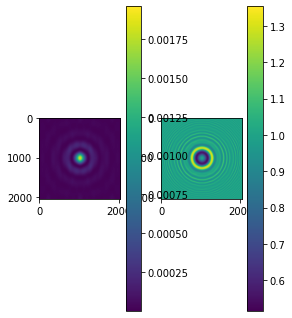

In [16]:
fig,axs=plt.subplots(1,2,figsize=(4,7))
cols=axs[0].imshow(I_babi[:,:,-1])
fig.colorbar(cols,ax=axs[0])
col=axs[1].imshow(I_gaus[...,-1])
fig.colorbar(col)

In [0]:
I_gaus_tri_2e3=datas(r=1e-2,n=5)

I'm in
Integration lasts:1.285028


(<Figure size 288x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f0d5ebe7160>)

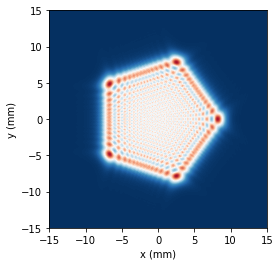

In [0]:
plot(I_gaus_tri_2e3[...,26])